# Pytorch classification on MNST digits


## Import the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive

## Set up GPU capabilities

The cell below sets up a CUDA device to use with torch, if available.

**Remember to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU

In [ ]:
# DO NOT MODIFY
torch.manual_seed(42) # For consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.2.1+cu121
cuda:0


In [ ]:
# Check device type is CUDA
device

device(type='cuda', index=0)

# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch`

In this project we will tackle the problem of classifying images.

Specifically, we would be looking at the Modified National Institute of Standards and Technology database ([MNIST](https://en.wikipedia.org/wiki/MNIST_database)) dataset.

<div>
<img src="https://s2.loli.net/2023/03/26/GwFJhNeskzE5Ptx.webp", width="800"/>
</div>

Diagram Reference: [Link](https://en.wikipedia.org/wiki/MNIST_database)

[MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) dataset consists of 60,000 28x28 grayscale images in 10 classes.

There are 60,000 training images and 10,000 test images.

While it is good to have as much training data as possible, in order to avoid having long training time and potentially running out of GPU, we will downsample and train the model with 30,000 training images and 5,000 testing images.


We would be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network
3.   Convolutional Neural Network

And analyze the difference between these models by looking at the test accuracy and loss.



## 1.1 Pytorch Dataset and DataLoader

*   **1.1.1 Instantiate Train and Test Dataset.** $\to$ Load and transform data such that it is ready to be passed into the model
*   **1.1.2 Instantiate Train and Test Dataloader.** $\to$ Put the data into the iterable such that the model is able to process data in batch from using `DataLoader`


### 1.1.1 Instantiate Dataset (for train/test dataset) (6 points)

Let us load and transform data such that it is ready to be passed into the model with the following transformations:

1.   Resize the image to 28 by 28 $\to$ just to make sure they are really have size $28$x$28$
2.   Convert the images to Tensor
3.   Rotate the image using `RandomRotation` with the range of rotation between $(-45°,45°)$
4.   Add random perspective shift using `RandomPerspective` with the distortion of `0.3` to `50%` of the data.
5.   Normalize the Tensor using mean value of `0.1307` and standard deviation value of `0.3081`


In [ ]:
scale = 28
distortion_scale=0.3

transform = transforms.Compose([
    transforms.Resize((scale, scale)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees = (-45, 45)),
    transforms.RandomPerspective(distortion_scale = distortion_scale, p=0.5),
    transforms.Normalize(mean=0.1307, std=0.3081)
    ])

Now that we have defined the tranforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Dataset.

In addition, since the whole dataset is pretty large for running the model, we will also be downsampling by reducing the size of the dataset by half.

Steps:
* Initiate the `Dataset` object for the training set as `train_dataset`
* Downsample training by getting the train data at even-numbered indices, specified as `train_subset`
* Initiate the `Dataset` object for the testing set as `test_dataset`
* Downsample testing by getting the test data at even-numbered indices, specified as `test_subset`


In [ ]:
train_dataset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform)
train_subset = torch.utils.data.Subset(train_dataset, [i for i in range(len(train_dataset)) if i % 2 == 0])

test_dataset = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, [i for i in range(len(test_dataset)) if i % 2 == 0])

100%|██████████| 9912422/9912422 [00:00<00:00, 142231086.91it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43527018.98it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33679375.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23461242.33it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Now let us transform the data

In [ ]:
transforms_train = []
for i in range(len(train_dataset.transform.transforms)):
  transforms_train.append(str(train_dataset.transform.transforms[i]))
transforms_test = []
for i in range(len(test_dataset.transform.transforms)):
  transforms_test.append(str(test_dataset.transform.transforms[i]))

### 1.1.2 Dataloader - Train / Test

Now that we have `trainDataset` and `testDataset`, let's create dataloaders using these two datasets.

In [ ]:
batch = 64

train_loader = DataLoader(train_subset , batch_size = batch, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_subset , batch_size = batch, shuffle = True, num_workers = 0)

## 1.2 Summarizing our Dataset

In this section, we will be looking at the distribution of the dataset (e.g., how many instances belong to class with label `0`) and visualize what we are dealing with (i.e., plot out the sample images)

### 1.2.1 Looking at the distribution of labels (6 points)

We can look at the distribution of labels by retrieving the labels of all possible instances of the subset of data pulled from `train_dataset` and `test_dataset` (i.e., `train_subset` and `test_subset`) for the training and testing data, respectively.

To do this, we can create a dictionary for the train and test sets that contains the labels as keys and the number of images inside the label as values.

In [ ]:
train_dataset.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Use the original train dataset (with 60,000 images) object to obtain the number of label classes train data
train_num_labels = len(train_dataset.targets.unique())

train_loader_bar_plot = DataLoader(train_subset, batch_size = len(test_subset), shuffle = True, num_workers = 0)

# Creating dictionary for train dataset
train_subset_dict = dict()

for images, labels in train_loader_bar_plot:
  for label in labels:
    label = label.item()
    if label not in train_subset_dict:
      train_subset_dict[label] = 0
    train_subset_dict[label] += 1

print(train_subset_dict)

{1: 3370, 4: 2958, 9: 3005, 2: 2996, 5: 2841, 0: 2819, 6: 2994, 7: 3149, 8: 2883, 3: 2985}


In [ ]:
# Use the original test dataset (with 10,000 images) object to obtain the number of label classes in test data
test_num_labels = len(test_dataset.targets.unique())

test_loader_bar_plot = DataLoader(test_subset, batch_size = len(test_subset), shuffle = True, num_workers = 0)

# Creating dictionary for test dataset
test_subset_dict = dict()

for images, labels in test_loader_bar_plot:
  for label in labels:
    label = label.item()
    if label not in test_subset_dict:
      test_subset_dict[label] = 0
    test_subset_dict[label] += 1

print(test_subset_dict)

{2: 501, 5: 458, 0: 451, 7: 519, 6: 499, 1: 591, 8: 466, 3: 511, 9: 524, 4: 480}


In [ ]:
test_features, test_labels = next(iter(test_loader_bar_plot))

### 1.2.2 Visualize through bar charts

Now we are going to visualize the distribution of labels using bar charts for both training and testing set which we store the distributions in their respective dictionary objects in section 1.2.1.

([<matplotlib.axis.XTick at 0x7d9236264bb0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

<Figure size 800x600 with 0 Axes>

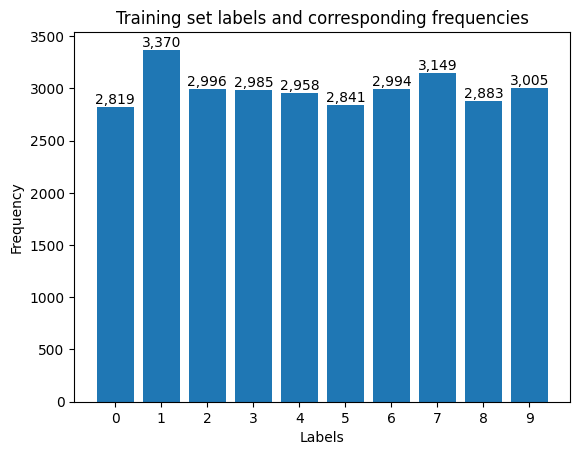

In [ ]:
# Create a barplot showing the distribution of the train dataset
plt.figure(figsize=(8, 6))

labels = list(train_subset_dict.keys())
freq = list(train_subset_dict.values())

fig, ax = plt.subplots()
bar_container = ax.bar(labels, freq)
ax.set(xlabel = 'Labels', ylabel='Frequency', title='Training set labels and corresponding frequencies')
ax.bar_label(bar_container, fmt='{:,.0f}')
plt.xticks(range(0, 10))



([<matplotlib.axis.XTick at 0x7d92360d6710>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

<Figure size 800x600 with 0 Axes>

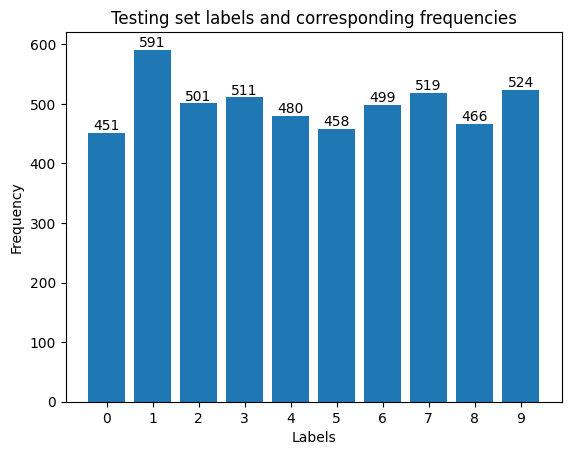

In [ ]:
# Create a barplot showing the distribution of the test dataset
plt.figure(figsize=(8, 6))

labels = list(test_subset_dict.keys())
freq = list(test_subset_dict.values())

fig, ax = plt.subplots()
bar_container = ax.bar(labels, freq)
ax.set(xlabel = 'Labels', ylabel='Frequency', title='Testing set labels and corresponding frequencies')
ax.bar_label(bar_container, fmt='{:,.0f}')
plt.xticks(range(0, 10))

### 1.2.3 Visualize the Training Dataset

Let's get a proper look at our training data. We'll look at a sample of images by plotting them with their labels.


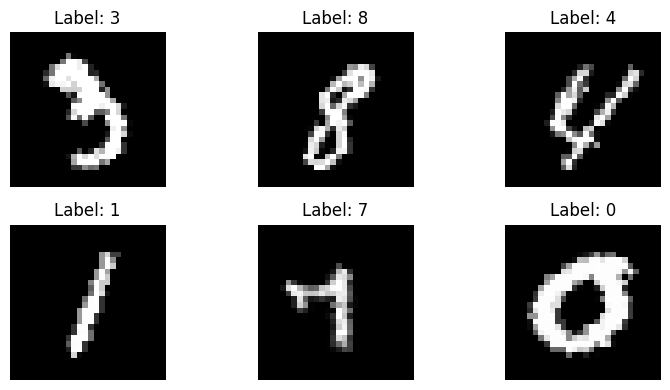

In [ ]:
torch.manual_seed(42)
sample_idxs = [10, 300, 700, 2708, 5035, 8000]

# loop through the length of tickers and keep track of index
fig, axes = plt.subplots(2, 3, figsize=(8, 4))

i = 0
for idx in sample_idxs:
  image, label = train_dataset[idx]

  image_np = image.squeeze().numpy()

  ax = axes[i // 3, i % 3]
  ax.imshow(image_np, cmap='gray')
  ax.set_title(f"Label: {label}")
  ax.axis('off')
  i += 1


plt.tight_layout()
plt.show()

# **Part 2:** Classification Models

We now have the data needed to train a multi-class object classifier. We will start simple with a logistic regression classifier as a baseline for our performance, before we move onto more complex neural networks.


## 2.1 Logical Logistic Regression - Baseline

Let's first try solving this problem with a Logistic Regression classifier.

We will define a logistic regression model in Pytorch and train it on our training set and evaluate the performance on the test set.

Logistic regression can be modelled as a function that can take in any number of inputs and constrain the output to be between 0 and 1. This means we can think of Logistic Regression as a one-layer neural network without hidden layers with Sigmoid as an activation function.

<div>
<img src='https://i.stack.imgur.com/fKvva.png',width='600'/>
</div>

Diagram Reference: [Link](https://stats.stackexchange.com/questions/366707/a-logistic-regression-with-neural-network-mindset-vs-a-shallow-neural-network)

### 2.1.1 Logistic Regression Model Architecture (5 points)

Our first model is a logistic regression model using Pytorch with the number of outputs equal to the number of classes in the model.

In [ ]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the neural network layers
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # Implement the operations on input data
        outputs = nn.Sequential(self.flatten, self.linear, self.sigmoid)(x)

        return outputs

Let's print the model summary

In [ ]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)

### 2.1.2 Training Logistic Regression Model


In [ ]:
%%time
# Sending the data to device (CPU or GPU)

# Instantiate the logistic regression to variable logreg
logreg = LogReg().to(device)
# Set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad() #?
      # Step 2: Feed the network the train data
      outputs = logreg(inputs).to(device)
      # Step 3: Get the prediction using argmax
      preds = torch.argmax(outputs, axis=1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels) #?
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item() * len(labels)

      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      correct += (preds == labels).sum().item()
      total += len(labels)

  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = 100 * correct / total
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  average_loss = running_loss / total
  loss_LIST_log.append(average_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 134.2579653400348, Accuracy = 45.74666666666667
The loss for Epoch 1 is: 124.49367659839231, Accuracy = 59.263333333333335
The loss for Epoch 2 is: 121.14841804016373, Accuracy = 61.27
The loss for Epoch 3 is: 119.39870982790298, Accuracy = 62.5
The loss for Epoch 4 is: 118.35292959314928, Accuracy = 62.54666666666667
The loss for Epoch 5 is: 117.54329795674728, Accuracy = 63.39666666666667
The loss for Epoch 6 is: 116.7935685603095, Accuracy = 63.70333333333333
The loss for Epoch 7 is: 116.41601136295017, Accuracy = 63.6
The loss for Epoch 8 is: 115.96743367729918, Accuracy = 64.05333333333333
The loss for Epoch 9 is: 115.82281884964087, Accuracy = 63.943333333333335
CPU times: user 5min 50s, sys: 1.51 s, total: 5min 52s
Wall time: 5min 56s


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression

Now let's plot the training accuracy vs epochs.

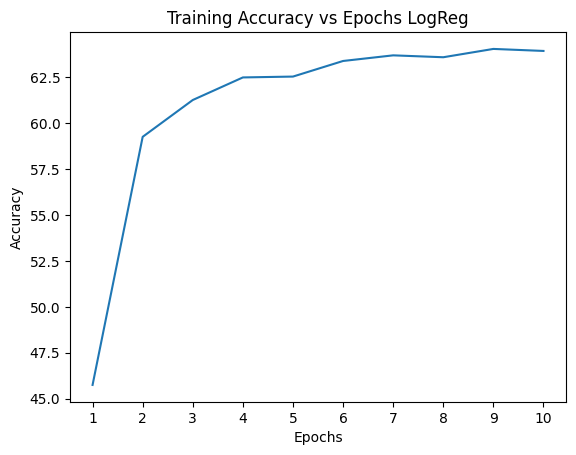

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figsize=(5,3)

sns.lineplot(x= list(range(1,11)), y=acc_LIST_log)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs LogReg')

plt.xticks(range(1, 11))

plt.show()

### 2.1.4 Logistic Regression Model Accuracy

Let's calculate the Test Accuracy for the Logistic Regression Model we trained above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = logreg(images).to(device)
        # Get the prediction using argmax
        preds = torch.argmax(outputs, axis=1)
        # Get number of correct prediction and add to correct and total
        correct += (preds == labels).sum()
        total += len(labels)

# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = 100 * correct / total

print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 64.55999755859375


## 2.2 Feedforward Neural Networks (Total: 25 points)

<div>
<img src='https://s2.loli.net/2022/11/21/dvqstVUzcQPChD1.png', width='400'/>
</div>

Diagram reference: [Link](https://en.wikipedia.org/wiki/Feedforward_neural_network)

Since logistic regression isn't that great at the classification problem above, we need more representation power in our model. We will now define a feedforward neural network.

### 2.2.1 Feedforward Neural Network Model Architecture

In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the neural network layers
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.input = nn.Linear(28 * 28, 32 * 32)
        self.hidden = nn.Linear(32 * 32, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        # Implement the operations on input data
        outputs = nn.Sequential(
            self.flatten,
            self.input,
            self.relu,
            self.hidden,
            self.relu,
            self.output)(x)

        return outputs

Let's print the model summary

In [ ]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (hidden): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

### 2.2.2 Training FNN Model

In [ ]:
%%time
# Sending the data to device (CPU or GPU)

# Step 1: instantiate the FNN model to variable fnn
fnn = FNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = fnn(inputs).to(device)
      # Step 3: Get the prediction using argmax
      preds = torch.argmax(outputs, axis=1)
      #preds = preds.type(torch.LongTensor) # Cast to Long

      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item() * len(labels)
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      correct += (preds == labels).sum().item()
      total += len(labels)
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  average_loss = running_loss / total
  loss_LIST_FNN.append(average_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 71.24878570418367, Accuracy = 65.02333333333333
The loss for Epoch 1 is: 43.723770257506544, Accuracy = 78.55
The loss for Epoch 2 is: 33.21581859324279, Accuracy = 84.03333333333333
The loss for Epoch 3 is: 27.413250632377576, Accuracy = 86.69333333333333
The loss for Epoch 4 is: 23.967950040089296, Accuracy = 88.42333333333333
The loss for Epoch 5 is: 21.492622433440772, Accuracy = 89.70666666666666
The loss for Epoch 6 is: 19.577913512044876, Accuracy = 90.47
The loss for Epoch 7 is: 17.388120141873227, Accuracy = 91.47333333333333
The loss for Epoch 8 is: 16.652196395117592, Accuracy = 91.91
The loss for Epoch 9 is: 16.11477472329699, Accuracy = 92.15
CPU times: user 5min 55s, sys: 1.32 s, total: 5min 56s
Wall time: 5min 59s


### 2.2.3 Plotting Training Accuracy vs Epochs FNN

Let's plot the training accuracy vs epochs.

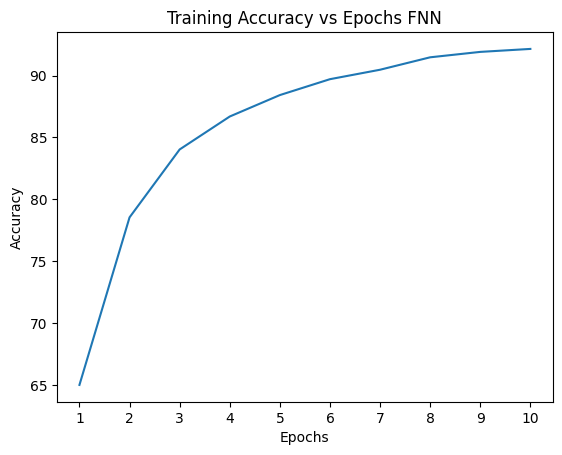

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figsize=(5,3)

sns.lineplot(x= list(range(1,11)), y=acc_LIST_FNN)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs FNN')

plt.xticks(range(1, 11))

plt.show()

### 2.2.4 FNN Model Accuracy

Now let's calculate the Test Accuracy for the FNN Model we trained above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = fnn(images).to(device)
        # Get the prediction using argmax
        preds = torch.argmax(outputs, axis=1)
        # Get number of correct prediction and add to correct and total
        correct += (preds == labels).sum()
        total += len(labels)


# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN = 100 * correct / total

print('Test Accuracy: ' + str(test_acc_FNN.item()))

Test Accuracy: 92.57999420166016


## 2.3 "Convoluted" Convolutional Neural Networks

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other.

<div>
<img src='https://s2.loli.net/2022/11/21/L6pUz2chXWRGn31.png', width='800'>
</div>

Diagram Reference: [Link](https://www.analyticsvidhya.com/blog/2020/10/what-is-the-convolutional-neural-network-architecture/)

We will define the architecture for the CNN we will be using. The components of a CNNs are as follows:

*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers (3 Points)

Before we start building the architecture, it's important to understand the dimensions of the feature maps produced in each of the convolution and pooling layers. We want to keep track of this information as once we get to the fully-connected layers, we need to specify the number of input parameters.

Let's first build a function that will help us calculate the dimensions based on the input parameters.


Since we are working with squared image, we will build just one function that can be used to calculate both the H (height) and W (width) of the feature map.

Below is the function used to calculate the output dimension of the feature map:

<div>
<img src='https://s2.loli.net/2023/03/30/lKpjPLVHcuRC8n2.png',width='300'/>
</div>

Diagram Reference: [Link](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  '''
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel

  ROUND DOWN if the result if a fraction.
  '''

  output = int((input_dim + 2 * padding - (kernel_size - 1) -1) / stride + 1)

  return output


### 2.3.1 Convolutional Neural Network Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Step 1: Initialize 1 - 3 convolution blocks (consists of a convolution layer, an activation function, a MaxPooling layer)

        # Convolution Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=2)
        # input dim = 1 channels, with image size 28 x 28
        # output dim = 3 channels, with image size 28 x 28
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Convolution Block 2
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=1, padding=1)
        # input dim = 1 channels, with image size 28 x 28
        # output dim = 32 channels, with image size 28 x 28
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Step 2: Flatten the 2D image into a 1D tensor
        self.flatten = nn.Flatten()

        # Step 3: Initialize 1-3 fully-connected layers
        self.fc1 = nn.Linear(1568, 10)

    def forward(self, x):
        # TODO
        outputs = nn.Sequential(self.conv1, self.relu, self.maxpool,
                                self.conv2, self.relu, self.maxpool,
                                self.flatten, self.fc1)(x)
        
        return outputs

Let's print out the model summary

In [ ]:
CNN()

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

### 2.3.2 Training CNN Model

Now let's train the CNN model.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# Step 1: instantiate the CNN model to variable cnn
cnn = CNN().to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_CNN = []
loss_LIST_CNN = []

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = cnn(inputs).to(device)
      # Step 3: Get the prediction using argmax
      preds = torch.argmax(outputs, axis=1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item() * len(labels)
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      # Hint: we need to detach the numbers from GPU to CPU, which stores accuracy and loss
      correct += (preds == labels).sum().item()
      total += len(labels)
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = 100 * correct / total
  acc_LIST_CNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  average_loss = running_loss / total
  loss_LIST_CNN.append(average_loss)

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))


The loss for Epoch 0 is: 110.51745534299025, Accuracy = 52.89
The loss for Epoch 1 is: 59.44714411794504, Accuracy = 72.19
The loss for Epoch 2 is: 46.27837343561624, Accuracy = 77.47666666666667
The loss for Epoch 3 is: 40.14523866181689, Accuracy = 80.77333333333333
The loss for Epoch 4 is: 36.22814946693144, Accuracy = 82.53
The loss for Epoch 5 is: 34.375384487322904, Accuracy = 83.77666666666667
The loss for Epoch 6 is: 31.828237952454003, Accuracy = 84.73666666666666
The loss for Epoch 7 is: 29.70958792273678, Accuracy = 85.78333333333333
The loss for Epoch 8 is: 28.461975177976367, Accuracy = 86.43666666666667
The loss for Epoch 9 is: 27.43527188738272, Accuracy = 86.65333333333334
CPU times: user 5min 48s, sys: 1.27 s, total: 5min 50s
Wall time: 5min 51s


### 2.3.3 Plotting Training Accuracy vs Epochs CNN

Let's plot the training accuracy vs epochs.

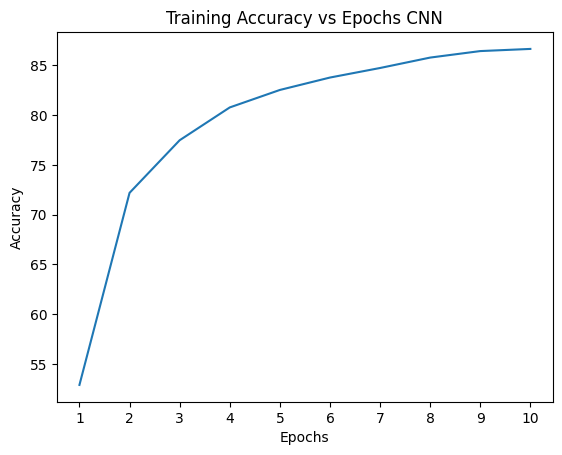

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# TODO
plt.figsize=(5,3)

sns.lineplot(x= list(range(1,11)), y=acc_LIST_CNN)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs CNN')

plt.xticks(range(1, 11))

plt.show()

### 2.3.4 CNN Model Test Accuracy

Now let's calculate the Test Accuracy for the CNN Model we trained above.

In [ ]:
# TODO
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = cnn(images).to(device)
        # Get the prediction using argmax
        preds = torch.argmax(outputs, axis=1)
        # Get number of correct prediction and add to correct and total
        correct += (preds == labels).sum()
        total += len(labels)

# Calculate test accuracy for CNN (should multiple by 100)
test_acc_CNN = 100 * correct / total


print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 86.97999572753906


## 2.4. Reflection



Let's compare the model performance:

From the test accuracies, we can see that both FNN and CNN work better than Logistic Regression.

In [ ]:
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 64.55999755859375
Test Accuracy for FNN: 92.57999420166016
Test Accuracy for CNN: 86.97999572753906
